In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import matplotlib.gridspec as gridspec
import cv2
import matplotlib.image as mpimg
import os
import pickle
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
%matplotlib inline

In [2]:
ls

annie_recovery/               data_acquisition.ipynb       recovery_laps_more/
CarND-Behavioral-Cloning-P3/  data_acquisition_method.txt  training_data_clr.p
clone-personal.ipynb          model1.h5                    training_data_g.p
data/                         model-weights1.h5            training_data.p
data_ac/                      Pipeline.ipynb               tree.txt
Data_ac_backwards_training/   recover_laps_backwards_2/
Data_Acquisition_2/           recovery_laps/


In [3]:
with open('training_data_clr.p', 'rb') as handle:
    training_data = pickle.load(handle)
    df = pd.DataFrame.from_dict(training_data)
    
    

In [4]:
X_train_data, X_valid_data = train_test_split(df, test_size = 0.2)


In [5]:
df.head(10)
print(len(df))
print(len(X_train_data))
print(len(X_valid_data))

50370
40296
10074


In [6]:
X_train_data.head(10)

,image,steer
42733,/home/jj/Documents/Behavioral_Cloning/data/IMG...,0.100000
16455,/home/jj/Documents/Behavioral_Cloning/data/IMG...,-0.028302
20889,/home/jj/Documents/Behavioral_Cloning/data_ac/...,-0.056604
5870,/home/jj/Documents/Behavioral_Cloning/recovery...,-0.081132
45764,/home/jj/Documents/Behavioral_Cloning/data/IMG...,-0.100000
50120,/home/jj/Documents/Behavioral_Cloning/data/IMG...,-0.100000
7926,/home/jj/Documents/Behavioral_Cloning/annie_re...,-0.037736
31734,/home/jj/Documents/Behavioral_Cloning/data/IMG...,0.090466
26328,/home/jj/Documents/Behavioral_Cloning/data/IMG...,0.000000
1842,/home/jj/Documents/Behavioral_Cloning/Data_ac_...,0.094340


#### View histogram of steering angles

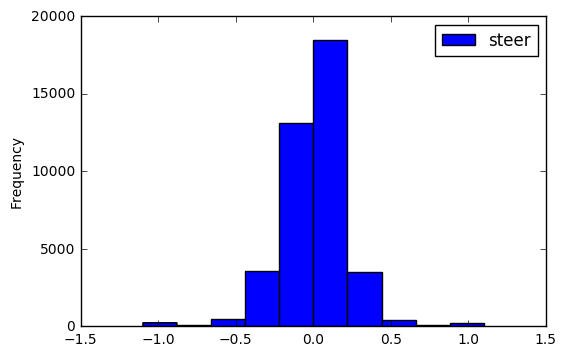

In [7]:
X_train_data.plot.hist('steer')

In [8]:
row = X_train_data.iloc[[2]]
print(row['steer'].values[0])

-0.0566038


#### As you can see, most of our steering angles are around zero

## Brightness Augmentation

## Horizontal and Vertical Shifts

## Flipping

In [9]:
rand_int = np.random.choice(len(X_train_data))

In [10]:
print('rand_int: ', rand_int)
row = X_train_data.iloc[[rand_int]]
impath = row['image'].values[0]
steer = row['steer'].values[0]
print('impath ', impath)
print('steer: ', steer)

img, ang = preprocess_image_from_path(impath, steer)
plt.imshow(img)
print('steer: ', ang)

# img = mpimg.imread(impath)
# plt.imshow(img)

rand_int:  14568
impath  /home/jj/Documents/Behavioral_Cloning/data/IMG/left_2016_12_01_13_46_24_618.jpg
steer:  0.162699


NameError: name 'preprocess_image_from_path' is not defined

## Preprocess

In [11]:
def preprocess_image(image):
    """
    Preprocess image, 
    input: image (original shape)
    output: image (shape is (200, 66, 3) )
    """
    # crop shape
    image = image[55:image.shape[0] - 24,:,:]
    # resize to (66, 200)
    img = cv2.resize(image, (200, 66), interpolation=cv2.INTER_AREA)
    return img


In [12]:
def preprocess_image_valid_from_path(image_path, steering_angle):
    img = mpimg.imread(image_path)
    img = preprocess_image(img)
    return img, steering_angle

In [13]:
def preprocess_image_from_path(image_path, steering_angle):
    img = mpimg.imread(image_path)
    img = preprocess_image(img)
    return img, steering_angle

## Generator

In [14]:

def generate_training_data(data, batch_size = 32):
    """
    We create a loop through out data and 
    send out an individual row in the dataframe to preprocess_image_from_path, 
    which is then sent to preprocess_image
    inputs: 
    data: pandas DataFrame
    batch_size: batch sizes, size to make each batch
    returns a yield (image_batch, label_batch)
    """
    image_batch = np.zeros((batch_size, 66, 200, 3)) # nvidia input params
    label_batch = np.zeros((batch_size))
    while True:
        for i in range(batch_size):
            idx = np.random.randint(len(data))
            row = data.iloc[[idx]].reset_index()
            x, y = preprocess_image_from_path(row['image'].values[0], row['steer'].values[0])
    
            image_batch[i] = x
            label_batch[i] = y
        yield (image_batch, label_batch)
    
def generate_validation_data(data):
    while True:
        for idx in range(len(data)):
            row = data.iloc[[idx]].reset_index()
            img, angle = preprocess_image_valid_from_path(row['image'].values[0], row['steer'].values[0])
            img = img.reshape(1, img.shape[0], img.shape[1], img.shape[2])
            angle = np.array([[angle]])
            yield img, angle
            

## Network

#### I chose to use Nvidia's network architecture. Input (200 x 66 sized image) output (1 steering angle)

In [15]:
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.core import Activation, Dropout, Flatten, Dense, Lambda
tf.python.control_flow_ops = tf


N_img_height = 66
N_img_width = 200
N_img_channels = 3
def nvidia_model():
    inputShape = (N_img_height, N_img_width, N_img_channels)

    model = Sequential()
    # normalization
    model.add(Lambda(lambda x: x / 127.5 - 1, input_shape = inputShape))
    # cropping 70 off top 25 off bottom
    # model.add(Cropping2D(cropping=((70,25), (0, 0)))) Probably going to do cropping in my process

    # subsample is strides
    model.add(Convolution2D(24, 5, 5, subsample=(2,2), activation='relu'))
    model.add(Convolution2D(36, 5, 5, subsample=(2,2),  activation='relu'))
    model.add(Convolution2D(48, 5, 5, subsample=(2,2),  activation='relu'))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(Convolution2D(64, 3, 3, activation='relu'))

    model.add(Flatten())
    model.add(Dense(100))
    model.add(Dense(50))
    model.add(Dense(10))
    model.add(Dense(1))
    
    model.compile(optimizer = 'adam', loss = 'mse', metrics = ['accuracy'])

    return model


Using TensorFlow backend.


In [16]:
print('len: ', len(X_valid_data))
print('len train :', len(X_train_data))

len:  10074
len train : 40296


In [17]:
val_size = len(X_valid_data)
valid_generator = generate_validation_data(X_valid_data)

In [18]:
train_generator = generate_training_data(X_train_data, 256)
model = nvidia_model()
history = model.fit_generator(
        train_generator, 
        samples_per_epoch = 20480, 
        nb_epoch = 8,
        validation_data = valid_generator,
        nb_val_samples = val_size)
print(history)
    
model.save_weights('model-weights1.h5')
model.save('model1.h5')

Epoch 1/8
20480/20480 [==============================] - 95s - loss: 0.0456 - acc: 0.1118 - val_loss: 0.0426 - val_acc: 0.1143
Epoch 2/8
20480/20480 [==============================] - 86s - loss: 0.0436 - acc: 0.1156 - val_loss: 0.0423 - val_acc: 0.1143
Epoch 3/8
20480/20480 [==============================] - 88s - loss: 0.0438 - acc: 0.1181 - val_loss: 0.0424 - val_acc: 0.1143
Epoch 4/8
20480/20480 [==============================] - 84s - loss: 0.0441 - acc: 0.1093 - val_loss: 0.0413 - val_acc: 0.1143
Epoch 5/8
20480/20480 [==============================] - 86s - loss: 0.0438 - acc: 0.1157 - val_loss: 0.0420 - val_acc: 0.1143
Epoch 6/8
20480/20480 [==============================] - 84s - loss: 0.0426 - acc: 0.1204 - val_loss: 0.0418 - val_acc: 0.1143
Epoch 7/8
20480/20480 [==============================] - 85s - loss: 0.0430 - acc: 0.1195 - val_loss: 0.0413 - val_acc: 0.1143
Epoch 8/8
20480/20480 [==============================] - 84s - loss: 0.0446 - acc: 0.1161 - val_loss: 0.0412 - 

In [19]:
print(model.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 66, 200, 3)    0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 31, 98, 24)    1824        lambda_1[0][0]                   
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 14, 47, 36)    21636       convolution2d_1[0][0]            
____________________________________________________________________________________________________
convolution2d_3 (Convolution2D)  (None, 5, 22, 48)     43248       convolution2d_2[0][0]            
___________________________________________________________________________________________

In [ ]:
print('yo')